In [1]:
# Imports
import matplotlib.pyplot as plt
import bagpy
import pandas as pd
import numpy as np

In [28]:
# read rosbag
path_bag2 = "/home/mohamed/catkin_ws/src/autonomx_state_estimator-master/rosbags_encoder/my_data1.bag"
bag = bagpy.bagreader(path_bag2)
# method = 'butterworth_trapezoidal'

[INFO]  Successfully created the data folder /home/mohamed/catkin_ws/src/autonomx_state_estimator-master/rosbags/my_data1.


In [74]:
# extract topics of interest
odom_data = pd.read_csv(bag.message_by_topic('/odom'))
position_data = pd.read_csv(bag.message_by_topic('/vehicle_position'))
velocity_data = pd.read_csv(bag.message_by_topic('/vehicle_velocities'))

In [75]:
# Select the Desired columns in odom_data
desired_columns = ['Time', 'pose.pose.position.x', 'pose.pose.position.y', 
                   'twist.twist.linear.x', 'twist.twist.linear.y', 
                   'twist.twist.linear.z', 'twist.twist.angular.z']

# Select only the desired columns
odom_data = odom_data[desired_columns]

# Rename Columns
odom_data = odom_data.rename(columns={
    'twist.twist.linear.z': 'linear_velocity',
    'pose.pose.position.x': 'position_x',
    'pose.pose.position.y': 'position_y',
    'twist.twist.linear.x': 'velocity_x',
    'twist.twist.linear.y': 'velocity_y',
    'twist.twist.angular.z': 'omega_z'
})

position_data = position_data.rename(columns={
    'x' : "encoder_x",
    'y' : "encoder_y",
    'z' : "encoder_theta"

})

velocity_data = velocity_data.rename(columns={
    'x' : "encoder_velocity",
    'y' : "Null",
    'z' : "encoder_omega"

})


In [76]:
# Calculate Time offset
offset_odom = odom_data['Time'].iloc[0]
offset_pos  = position_data['Time'].iloc[0]
offset_vel  = velocity_data['Time'].iloc[0]

# Subtract the offset from all values in the "Time" column
odom_data['Time'] = odom_data['Time'] - offset_odom
position_data['Time'] = position_data['Time'] - offset_pos
velocity_data['Time'] = velocity_data['Time'] - offset_vel

print(f"Odom: {offset_odom}\npos : {offset_pos}\nvel : {offset_vel}")

Odom: 1713508308.983307
pos : 1713508309.0883856
vel : 1713508309.0885804


In [77]:
# Calculate Euclidean distance (magnitude) from velocity_x and velocity_y
odom_data['linear_velocity'] = np.sqrt(odom_data['velocity_x']**2 + odom_data['velocity_y']**2)

In [78]:
odom_data.head()

position_data.head()

velocity_data.head()

,Time,encoder_velocity,Null,encoder_omega
0,0.000000,0.000018,0.0,0.000012
1,0.006802,0.000019,0.0,-0.000004
2,0.013711,0.000005,0.0,0.000004
3,0.019965,0.000005,0.0,-0.000001
4,0.026927,0.000010,0.0,-0.000007


In [79]:
# Sort each DataFrame by the "Time" column
# odom_data_sorted = odom_data.sort_values('Time')
# position_data_sorted = position_data.sort_values('Time')
# velocity_data_sorted = velocity_data.sort_values('Time')

# Perform asof merge on the closest timestamps
merged_data = pd.merge_asof(odom_data, position_data, on="Time")
merged_data = pd.merge_asof(merged_data, velocity_data, on="Time")

# Create a new DataFrame with the desired columns
my_data = pd.DataFrame({
    'Time': merged_data['Time'],
    'position_x': merged_data['position_x'],
    'encoder_x': merged_data['encoder_x'],
    'position_y': merged_data['position_y'],
    'encoder_y': merged_data['encoder_y'],
    'encoder_theta': merged_data['encoder_theta'],
    'linear_velocity': merged_data['linear_velocity'],
    'encoder_velocity': merged_data['encoder_velocity'],
    'omega_z': merged_data['omega_z'],
    'encoder_omega': merged_data['encoder_omega']
})

#reset the index of the new DataFrame
my_data = my_data.reset_index(drop=True)


In [85]:
my_data.head()

my_data.tail()

,Time,position_x,encoder_x,position_y,encoder_y,encoder_theta,linear_velocity,encoder_velocity,omega_z,encoder_omega
8130,56.612590,-16.451347,-15.346247,18.841993,19.284735,171.584158,1.998629,2.000541,0.000011,-2.153395e-15
8131,56.619078,-16.471046,-15.346247,18.845369,19.284735,171.584158,1.998629,2.000541,0.000016,-2.153395e-15
8132,56.626977,-16.490747,-15.346247,18.848745,19.284735,171.584158,1.998817,2.000541,0.000008,-2.153395e-15
8133,56.634411,-16.510443,-15.346247,18.852121,19.284735,171.584158,1.998253,2.000541,0.000011,-2.153395e-15
8134,56.641320,-16.530140,-15.346247,18.855497,19.284735,171.584158,1.998441,2.000541,0.000049,-2.153395e-15


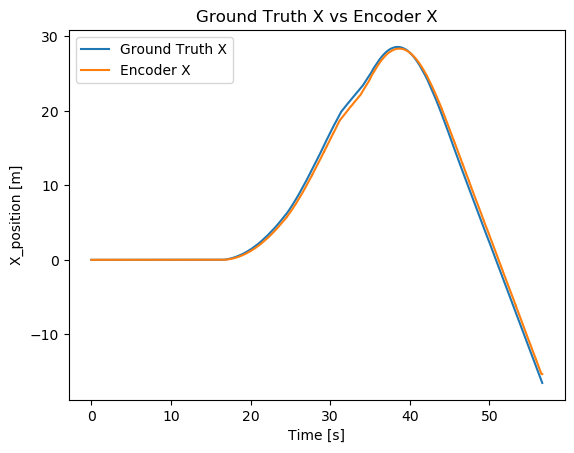

In [81]:
# Plot position X
# Plot position_x and encoder_x against Time
plt.plot(my_data['Time'].values, my_data['position_x'].values, label='Ground Truth X')
plt.plot(my_data['Time'].values, my_data['encoder_x'].values, label='Encoder X')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('X_position [m]')
plt.title('Ground Truth X vs Encoder X')

# Add legend
plt.legend()

# Show plot
plt.show()



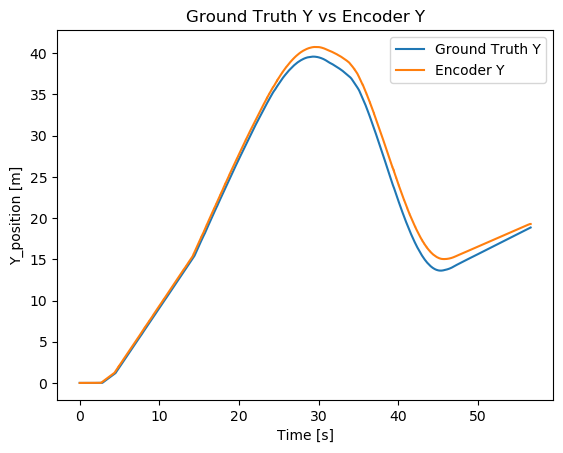

In [82]:
# Plot position Y
plt.plot(my_data['Time'].values, my_data['position_y'].values, label='Ground Truth Y')
plt.plot(my_data['Time'].values, my_data['encoder_y'].values, label='Encoder Y')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Y_position [m]')
plt.title('Ground Truth Y vs Encoder Y')

# Add legend
plt.legend()

# Show plot
plt.show()


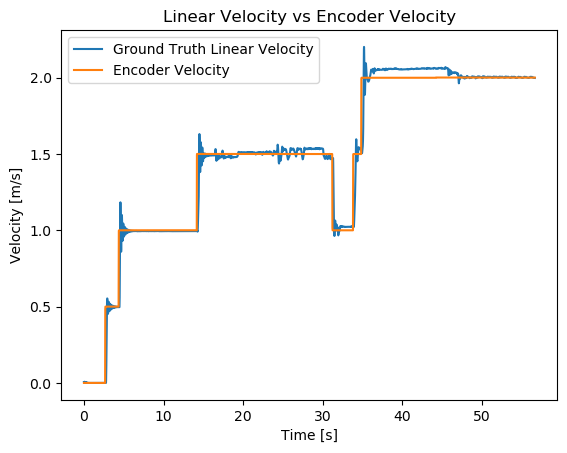

In [83]:
# Plot both linear velocity and encoder velocity on the same plot
plt.plot(my_data['Time'].values, my_data['linear_velocity'].values, label='Ground Truth Linear Velocity')
plt.plot(my_data['Time'].values, my_data['encoder_velocity'].values, label='Encoder Velocity')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Linear Velocity vs Encoder Velocity')

# Add legend
plt.legend()

# Show plot
plt.show()


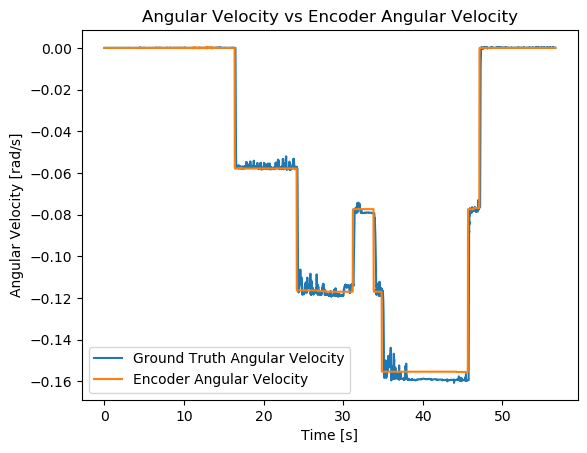

In [86]:
# Plot both omega_z and encoder_omega on the same plot
plt.plot(my_data['Time'].values, my_data['omega_z'].values, label='Ground Truth Angular Velocity')
plt.plot(my_data['Time'].values, my_data['encoder_omega'].values, label='Encoder Angular Velocity')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.title('Angular Velocity vs Encoder Angular Velocity')

# Add legend
plt.legend()

# Show plot
plt.show()
